/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Epoch [1/15], Loss: 2.3108, Accuracy: 9.96%
Epoch [2/15], Loss: 2.3214, Accuracy: 8.96%
Epoch [3/15], Loss: 2.3496, Accuracy: 9.63%
Epoch [5/15], Loss: 2.1424, Accuracy: 18.16%
Epoch [6/15], Loss: 2.0066, Accuracy: 27.03%
Epoch [7/15], Loss: 1.8630, Accuracy: 33.32%
Epoch [8/15], Loss: 1.7935, Accuracy: 37.04%
Epoch [9/15], Loss: 1.6595, Accuracy: 43.52%
Epoch [10/15], Loss: 1.5765, Accuracy: 46.57%
Epoch [11/15], Loss: 1.4597, Accuracy: 49.05%
Epoch [12/15], Loss: 1.3640, Accuracy: 52.67%
Epoch [13/15], Loss: 1.2120, Accuracy: 57.58%
Epoch [14/15], Loss: 1.2886, Accuracy: 56.53%
Epoch [15/15], Loss: 1.1570, Accuracy: 58.82%


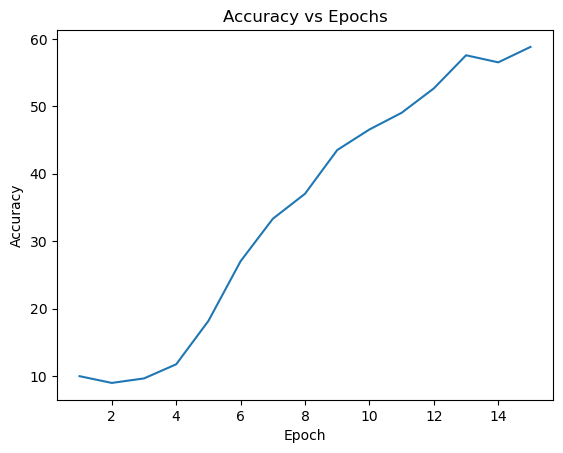

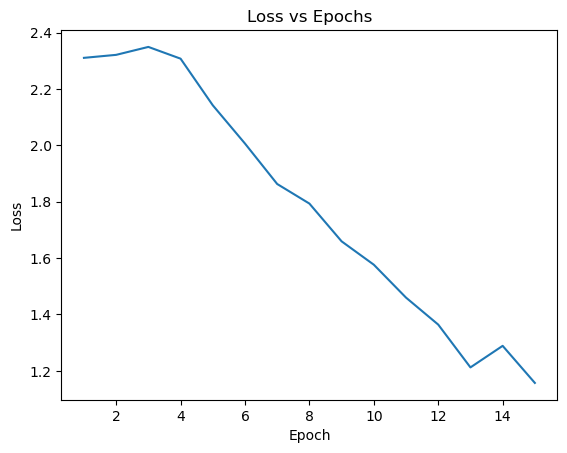

Predicted Class: cars
Confidence: 59.47%


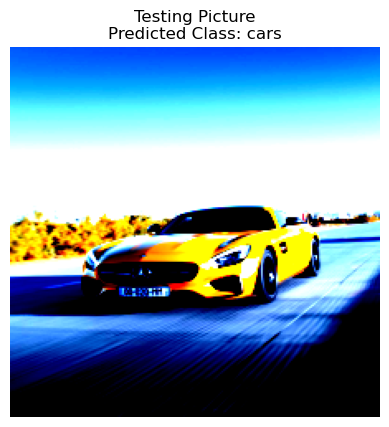

<Figure size 800x800 with 0 Axes>

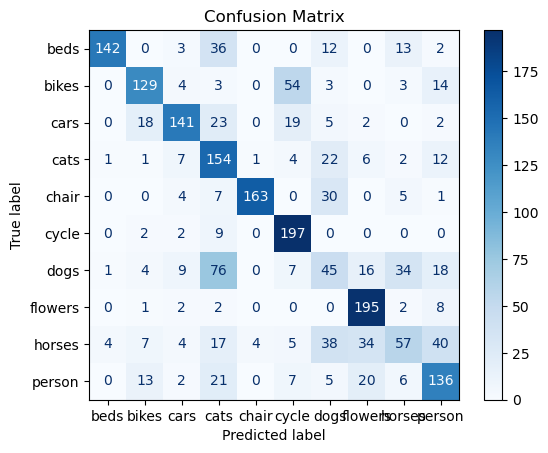

AttributeError: 'tuple' object has no attribute 'data'

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


dir = '/kaggle/input/dataset1/DL Dataset/'

# Define the list of target genres
classes = ['beds', 'bikes', 'cars', 'cats', 'chair', 'cycle', 'dogs', 'flowers', 'horses', 'person']

accuracy_values = []
loss_values = []

# Define the transformation to apply to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom dataset class for loading the images
class CustomDataset(Dataset):
    def __init__(self, dir, classes, transform=None):
        self.dir = dir
        self.classes = classes
        self.transform = transform
        self.image_files = []
        self.labels = []

        # Initialize label encoder
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(classes)

        # Iterate over each folder
        for classe in classes:
            classe_dir = os.path.join(dir, classe)
            if os.path.isdir(classe_dir):
                files = os.listdir(classe_dir)
                self.image_files.extend(files)
                self.labels.extend([classe] * len(files))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.dir, self.labels[idx], self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        label = self.label_encoder.transform([label])[0]

        return image, label


# Create the dataset and dataloader
dataset = CustomDataset(dir, classes, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define the GoogLeNet model
class GoogLeNet(nn.Module):
    def __init__(self, num_classes):
        super(GoogLeNet, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2),
            nn.Conv2d(64, 64, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)
        )

        self.a3 = InceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.b3 = InceptionModule(256, 128, 128, 192, 32, 96, 64)

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

        self.a4 = InceptionModule(480, 192, 96, 208, 16, 48, 64)
        self.b4 = InceptionModule(512, 160, 112, 224, 24, 64, 64)
        self.c4 = InceptionModule(512, 128, 128, 256, 24, 64, 64)
        self.d4 = InceptionModule(512, 112, 144, 288, 32, 64, 64)
        self.e4 = InceptionModule(528, 256, 160, 320, 32, 128, 128)

        self.aux1 = InceptionAux(512, num_classes)

        self.a5 = InceptionModule(832, 256, 160, 320, 32, 128, 128)
        self.b5 = InceptionModule(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.dropout = nn.Dropout(0.4)

        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.pre_layers(x)
        x = self.a3(x)
        x = self.b3(x)
        x = self.maxpool(x)
        x = self.a4(x)

        # Auxiliary Softmax classifier 1
        aux1 = self.aux1(x)

        x = self.b4(x)
        x = self.c4(x)
        x = self.d4(x)
        x = self.e4(x)
        x = self.maxpool(x)
        x = self.a5(x)
        x = self.b5(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)

        return x, aux1

class InceptionModule(nn.Module):
    def __init__(self, in_channels, out1x1, reduce3x3, out3x3, reduce5x5, out5x5, out1x1_pool):
        super(InceptionModule, self).__init__()

        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, out1x1, kernel_size=1)
        )

        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, reduce3x3, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(reduce3x3, out3x3, kernel_size=3, padding=1)
        )

        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, reduce5x5, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(reduce5x5, out5x5, kernel_size=5, padding=2)
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1, ceil_mode=True),
            nn.Conv2d(in_channels, out1x1_pool, kernel_size=1)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        output = torch.cat([branch1, branch2, branch3, branch4], 1)

        return output

class InceptionAux(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()

        self.average_pooling = nn.AvgPool2d(kernel_size=5, stride=3)
        self.conv = nn.Conv2d(in_channels, 128, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.average_pooling(x)
        x = self.conv(x)
        x = self.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

# Modify the last fully connected layer for the number of classes
num_classes = len(classes)

# Create the GoogLeNet model
model = GoogLeNet(num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 15
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs, _ = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Track the loss
        running_loss += loss.item() * images.size(0)

        # Track the accuracy
        _, predicted_labels = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted_labels == labels).sum().item()


    epoch_loss = running_loss / len(dataset)
    epoch_accuracy = (correct_predictions / total_predictions) * 100

    accuracy_values.append(epoch_accuracy)
    loss_values.append(epoch_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

plt.plot(range(1, num_epochs+1), accuracy_values)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.show()

plt.plot(range(1, num_epochs+1), loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.show()

# Save the trained model
torch.save(model.state_dict(), '/kaggle/working/googlenetmodel.pth')


import numpy as np

# Load the trained model
model = GoogLeNet(num_classes)
model.load_state_dict(torch.load('/kaggle/working/googlenetmodel.pth'))
model.to(device)
model.eval()

# Load and preprocess the input image
input_image_path = '/kaggle/input/testing1/testing/car_test.jpeg'  # Replace with the path to your input image
input_image = Image.open(input_image_path).convert('RGB')
input_image_transformed = transform(input_image)
input_image_tensor = input_image_transformed.unsqueeze(0)  # Add an extra dimension for batch size

# Move the input tensor to the same device as the model
input_image_tensor = input_image_tensor.to(device)

# Test the input image
with torch.no_grad():
    output, _ = model(input_image_tensor)
    _, predicted_label = torch.max(output, 1)

predicted_class = classes[predicted_label.item()]
confidence = torch.softmax(output, dim=1)[0, predicted_label].item() * 100

# Print the predicted class and confidence
print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence:.2f}%")

# Display the testing picture with the predicted class
plt.imshow(np.transpose(input_image_transformed, (1, 2, 0)))
plt.axis('off')
plt.title(f'Testing Picture\nPredicted Class: {predicted_class}', fontsize=12)
plt.show()


# Create lists to store predicted labels and ground truth labels
all_predicted_labels = []
all_ground_truth_labels = []

# Test the model on all test images
model.eval()
with torch.no_grad():
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs, _ = model(images)
        _, predicted_labels = torch.max(outputs.data, 1)

        all_predicted_labels.extend(predicted_labels.cpu().numpy())
        all_ground_truth_labels.extend(labels.cpu().numpy())

# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_ground_truth_labels, all_predicted_labels)

# Display the confusion matrix
plt.figure(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


test_correct_predictions = 0
test_total_predictions = 0

model.eval()
with torch.no_grad():
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted_labels = torch.max(outputs.data, 1)

        test_total_predictions += labels.size(0)
        test_correct_predictions += (predicted_labels == labels).sum().item()

    test_accuracy = (test_correct_predictions / test_total_predictions) * 100
    accuracy_values.append(test_accuracy)

    print(f"Testing Accuracy: {test_accuracy:.2f}%")



# Plot both training and testing accuracy
combined_epochs = [epoch for epoch in range(1, num_epochs + 1) for _ in range(2)]  # Duplicate epoch numbers for training and testing
plt.plot(combined_epochs, accuracy_values)  # Plot using the combined epochs list
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend(['Training', 'Testing'])
plt.show()

Epoch 1/30: Train Loss: 2.3374, Train Accuracy: 9.8331%, Test Accuracy: 7.3810%
Epoch 2/30: Train Loss: 2.3147, Train Accuracy: 9.4160%, Test Accuracy: 11.1905%
Epoch 3/30: Train Loss: 2.3137, Train Accuracy: 11.7998%, Test Accuracy: 8.3333%
Epoch 4/30: Train Loss: 2.2919, Train Accuracy: 12.0977%, Test Accuracy: 17.6190%
Epoch 5/30: Train Loss: 2.3279, Train Accuracy: 12.9321%, Test Accuracy: 5.4762%
Epoch 6/30: Train Loss: 2.1249, Train Accuracy: 21.5733%, Test Accuracy: 28.0952%
Epoch 7/30: Train Loss: 1.9967, Train Accuracy: 25.6257%, Test Accuracy: 29.2857%
Epoch 8/30: Train Loss: 1.9312, Train Accuracy: 29.9166%, Test Accuracy: 34.5238%
Epoch 9/30: Train Loss: 1.8884, Train Accuracy: 31.2277%, Test Accuracy: 37.3810%
Epoch 10/30: Train Loss: 1.7821, Train Accuracy: 37.0679%, Test Accuracy: 34.7619%
Epoch 11/30: Train Loss: 1.7083, Train Accuracy: 39.0942%, Test Accuracy: 43.8095%
Epoch 12/30: Train Loss: 1.7123, Train Accuracy: 40.4052%, Test Accuracy: 43.8095%
Epoch 13/30: Train

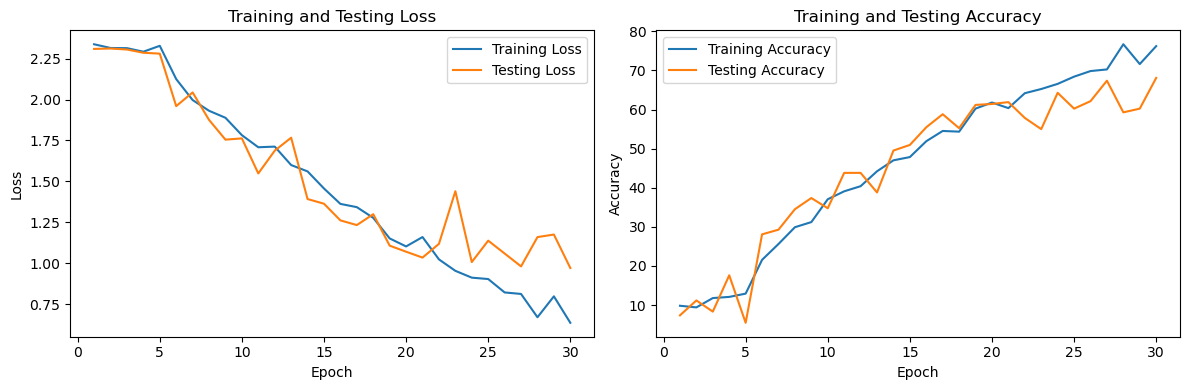

Predicted Class: horses
Confidence: 41.66%


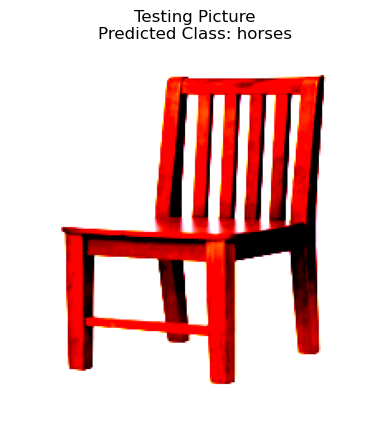

ValueError: Found input variables with inconsistent numbers of samples: [420, 56]

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from PIL import Image
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchvision import models
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report

# Define the directory containing the objects images
objects_dir = '/kaggle/input/dataset1/DL Dataset'

# Define the list of target objects classes
classes = ['beds', 'bikes', 'cars', 'cats', 'chair', 'cycle', 'dogs', 'flowers', 'horses', 'person']

train_accuracy_values = []
test_accuracy_values = []
loss_values = []

# Define the transformation to apply to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom dataset class for loading the objectimages
class ObjectDataset(Dataset):
    def __init__(self, objects_dir, classes, transform=None):
        self.objects_dir = objects_dir
        self.classes = classes
        self.transform = transform
        self.image_files = []
        self.labels = []

        # Initialize label encoder
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(classes)

        # Iterate over each class folder
        for classe in classes:
            classe_dir = os.path.join(objects_dir, classe)
            if os.path.isdir(classe_dir):
                files = os.listdir(classe_dir)
                self.image_files.extend(files)
                self.labels.extend([classe] * len(files))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.objects_dir, self.labels[idx], self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        label = self.label_encoder.transform([label])[0]

        return image, label


# Create the dataset
dataset = ObjectDataset(objects_dir, classes, transform=transform)

# Split the dataset into training and testing sets
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

# Create the dataloaders for training and testing
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the GoogLeNet model
class GoogLeNet(nn.Module):
    def __init__(self, num_classes):
        super(GoogLeNet, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2),
            nn.Conv2d(64, 64, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)
        )

        self.a3 = InceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.b3 = InceptionModule(256, 128, 128, 192, 32, 96, 64)

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

        self.a4 = InceptionModule(480, 192, 96, 208, 16, 48, 64)
        self.b4 = InceptionModule(512, 160, 112, 224, 24, 64, 64)
        self.c4 = InceptionModule(512, 128, 128, 256, 24, 64, 64)
        self.d4 = InceptionModule(512, 112, 144, 288, 32, 64, 64)
        self.e4 = InceptionModule(528, 256, 160, 320, 32, 128, 128)

        self.aux1 = InceptionAux(512, num_classes)

        self.a5 = InceptionModule(832, 256, 160, 320, 32, 128, 128)
        self.b5 = InceptionModule(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.dropout = nn.Dropout(0.4)

        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.pre_layers(x)
        x = self.a3(x)
        x = self.b3(x)
        x = self.maxpool(x)
        x = self.a4(x)

        # Auxiliary Softmax classifier 1
        aux1 = self.aux1(x)

        x = self.b4(x)
        x = self.c4(x)
        x = self.d4(x)
        x = self.e4(x)
        x = self.maxpool(x)
        x = self.a5(x)
        x = self.b5(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)

        return x, aux1

class InceptionModule(nn.Module):
    def __init__(self, in_channels, out1x1, reduce3x3, out3x3, reduce5x5, out5x5, out1x1_pool):
        super(InceptionModule, self).__init__()

        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, out1x1, kernel_size=1)
        )

        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, reduce3x3, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(reduce3x3, out3x3, kernel_size=3, padding=1)
        )

        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, reduce5x5, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(reduce5x5, out5x5, kernel_size=5, padding=2)
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1, ceil_mode=True),
            nn.Conv2d(in_channels, out1x1_pool, kernel_size=1)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        output = torch.cat([branch1, branch2, branch3, branch4], 1)

        return output

class InceptionAux(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()

        self.average_pooling = nn.AvgPool2d(kernel_size=5, stride=3)
        self.conv = nn.Conv2d(in_channels, 128, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.average_pooling(x)
        x = self.conv(x)
        x = self.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

# Modify the last fully connected layer for the number of classes
num_classes = len(classes)

model = GoogLeNet(num_classes)


# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    # Training loop
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        main_output, _ = model(images)  # Separate main output from auxiliary output
        loss = criterion(main_output, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

        _, predicted = torch.max(main_output.data, 1)  # Use main_output for prediction
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_loss /= len(train_dataset)
    train_losses.append(train_loss)

    train_accuracy = (train_correct / train_total)*100
    train_accuracies.append(train_accuracy)

    # Evaluation loop
    # Evaluation loop
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            main_output, _ = model(images)  # Use main output
            _, predicted = torch.max(main_output, 1)  # Use main_output for prediction
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss = criterion(main_output, labels)
            test_loss += loss.item() * images.size(0)

    test_loss /= len(test_dataset)
    test_losses.append(test_loss)

    accuracy = (correct / total) * 100
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}%, Test Accuracy: {accuracy:.4f}%")

# Plotting the graphs
plt.figure(figsize=(12, 4))

# Plot training and testing losses
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()

# Plot training and testing accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()

# Adjust the layout and display the graphs
plt.tight_layout()
plt.show()

# Save the trained model
torch.save(model.state_dict(), '/kaggle/working//model1.pth')


import numpy as np

# Load the trained model
model = GoogLeNet(num_classes)
model.load_state_dict(torch.load('/kaggle/working//model1.pth'))
model.to(device)
model.eval()

input_image_path = '/kaggle/input/testing1/testing/chair_test.jpg'  # Replace with the path to your input image
input_image = Image.open(input_image_path).convert('RGB')
input_image_transformed = transform(input_image)
input_image_tensor = input_image_transformed.unsqueeze(0)  # Add an extra dimension for batch size

# Move the input tensor to the same device as the model
input_image_tensor = input_image_tensor.to(device)

# Test the input image
with torch.no_grad():
    output, _ = model(input_image_tensor)  # Use output, _ for GoogLeNet's main output
    _, predicted_label = torch.max(output, 1)

predicted_class = classes[predicted_label.item()]
confidence = torch.softmax(output, dim=1)[0, predicted_label].item() * 100


# Print the predicted class and confidence
print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence:.2f}%")


# Display the testing picture with the predicted class
plt.imshow(np.transpose(input_image_transformed, (1, 2, 0)))
plt.axis('off')
plt.title(f'Testing Picture\nPredicted Class: {predicted_class}', fontsize=12)
plt.show()


import seaborn as sns



# Get true labels and predicted labels for the test set
Y_true = []
Y_pred = []
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(main_output, 1)

        Y_true.extend(labels.cpu().numpy())
        Y_pred.extend(predicted.cpu().numpy())

Y_true = np.array(Y_true)
Y_pred = np.array(Y_pred)

cm = confusion_matrix(Y_true, Y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print("Classification Report:")
print(classification_report(Y_true, Y_pred, target_names=classes))